# bottleneck

In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg19 import preprocess_input, VGG19
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

import numpy as np
import math

Using TensorFlow backend.


In [2]:
PATH_TO_DF = "../data/output_convnet/VGG19"

img_width = 150
img_height = 150

n_epochs = 50
batch_size = 16

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

n_train_samples = 3000
n_validation_samples = 1000
n_test_samples = 1000
n_classes = 8

In [3]:
# https://b/log.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# saving bottleneck features
import time

ti_bn_features = time.time()

model = VGG19(include_top=False, weights='imagenet')

datagen = ImageDataGenerator(rescale=1. / 255)

'''
https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L1002
if PIL version 1.1.3 interpolation = 'lanczos'
else interpolation = 'bicubic' 
''' 

# train
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False,
    interpolation = 'lanczos')

# important step in order to get the exact number
max_queue_size_train = int(math.ceil(n_train_samples / batch_size))

bnfeatures_train = model.predict_generator(
    generator, max_queue_size_train)

np.save('../data/output_convnet/VGG19/VGG19_bnfeatures_train.npy', bnfeatures_train)

# validation
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    interpolation = 'lanczos')

max_queue_size_val = int(math.ceil(n_validation_samples / batch_size))

   
bnfeatures_val = model.predict_generator(  
     generator, max_queue_size_val)

np.save('../data/output_convnet/VGG19/VGG19_bnfeatures_val.npy', bnfeatures_val)


tf_bn_features = time.time()    
tt_bn_features = tf_bn_features - ti_bn_features

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [4]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_features)))

00:00:37


In [5]:
# training top layer
import os

ti_bn_train = time.time()

# we have to get the classes names so we build again a generator
datagen_top_layer = ImageDataGenerator(rescale=1./255)  

# train
generator_top_layer = datagen_top_layer.flow_from_directory(
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode='categorical',  
    shuffle=False,
    interpolation = 'lanczos')  

train_data = np.load('../data/output_convnet/VGG19/VGG19_bnfeatures_train.npy')

# ref attribute classes --> https://keras.io/preprocessing/image/
train_labels = generator_top_layer.classes # the key attribute
train_labels = to_categorical(train_labels, num_classes=n_classes) # the key function

# validation
generator_top_layer = datagen_top_layer.flow_from_directory(  
    validation_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False,
    interpolation = 'lanczos')  

val_data = np.load('../data/output_convnet/VGG19/VGG19_bnfeatures_val.npy') 

val_labels = generator_top_layer.classes # the key attribute
val_labels = to_categorical(val_labels, num_classes=n_classes) # the key function


# top model, could be with a diff dense, optimizer, momentum -> https://keras.io/optimizers/
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(n_classes, activation='softmax'))  


model.compile(optimizer=SGD(lr=0.001),
              loss='categorical_crossentropy', metrics=['accuracy']) 


historical_data = model.fit(train_data, train_labels,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(val_data, val_labels))  

# h5py
model.save_weights('../data/output_convnet/VGG19/VGG19_bn_model.h5')  

tf_bn_train = time.time()    
tt_bn_train = tf_bn_train - ti_bn_train

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 1s 492us/step - loss: 1.6503 - acc: 0.4070 - val_loss: 1.2588 - val_acc: 0.6210
Epoch 2/50
3000/3000 [==============================] - 1s 297us/step - loss: 1.2226 - acc: 0.5797 - val_loss: 1.0116 - val_acc: 0.7180
Epoch 3/50
3000/3000 [==============================] - 1s 320us/step - loss: 1.0448 - acc: 0.6480 - val_loss: 0.8844 - val_acc: 0.7350
Epoch 4/50
3000/3000 [==============================] - 1s 299us/step - loss: 0.9547 - acc: 0.6810 - val_loss: 0.7982 - val_acc: 0.7940
Epoch 5/50
3000/3000 [==============================] - 1s 294us/step - loss: 0.8773 - acc: 0.7087 - val_loss: 0.7620 - val_acc: 0.7560
Epoch 6/50
3000/3000 [==============================] - 1s 295us/step - loss: 0.8362 - acc: 0.7217 - val_loss: 0.7024 - val_acc: 0.7980
Epoch 7/50
3000/3000 [==============================

In [6]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_bn_train)))

00:00:46


In [7]:
import h5py
hdf5_file = h5py.File('../data/output_convnet/VGG19/VGG19_bn_model.h5', mode='r')
print(list(hdf5_file))

['dense_1', 'dense_2', 'dropout_1', 'flatten_1']


In [8]:
(loss, acc) = model.evaluate(val_data, val_labels, batch_size=batch_size, verbose=0)
print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))  

acc: 84.80% - loss: 0.405727


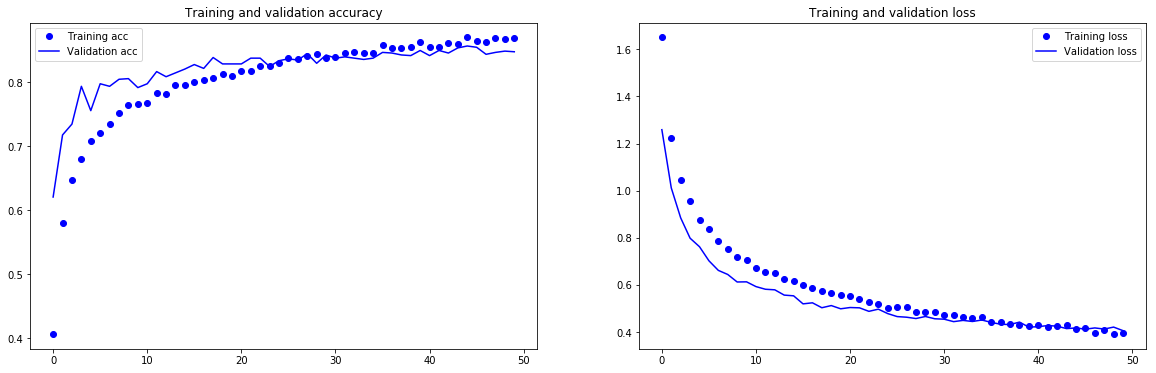

In [10]:
# historical_data.history acc and loss data over the epochs (train and validation)
import matplotlib.pyplot as plt

train_acc = historical_data.history['acc']
train_loss = historical_data.history['loss']

val_acc = historical_data.history['val_acc'] # validation
val_loss = historical_data.history['val_loss'] # validation

range_epochs = range(n_epochs)

fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plt.plot(range_epochs, train_acc, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1,2,2)
plt.plot(range_epochs, train_loss, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(os.path.join(PATH_TO_DF, "VGG19_bn_acc_loss.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb
plt.show()

# fine tuning

In [11]:
# check them out
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input

In [12]:
top_model_weights_path = '../data/output_convnet/VGG19/VGG19_bn_model.h5'
batch_size = 5 # reduce to 5 in order to be able to compute the calcs

In [14]:
# base model
input_tensor = Input(shape=(img_width,img_height,3)) # another way to shape the input
base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)

In [15]:
# top model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(8, activation='softmax'))

In [16]:
# base model has its weights, now we load the weights on the top layer
top_model.load_weights("../data/output_convnet/VGG19/VGG19_bn_model.h5")

In [17]:
# we join base and top it has to be updated to api2
model_total = Model(input= base_model.input, output= top_model(base_model.output))

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [18]:
# sequential is the top layer a complex one
for i, layer in enumerate(model_total.layers):
    print (i, layer.name, layer.output_shape)

0 input_3 (None, 150, 150, 3)
1 block1_conv1 (None, 150, 150, 64)
2 block1_conv2 (None, 150, 150, 64)
3 block1_pool (None, 75, 75, 64)
4 block2_conv1 (None, 75, 75, 128)
5 block2_conv2 (None, 75, 75, 128)
6 block2_pool (None, 37, 37, 128)
7 block3_conv1 (None, 37, 37, 256)
8 block3_conv2 (None, 37, 37, 256)
9 block3_conv3 (None, 37, 37, 256)
10 block3_conv4 (None, 37, 37, 256)
11 block3_pool (None, 18, 18, 256)
12 block4_conv1 (None, 18, 18, 512)
13 block4_conv2 (None, 18, 18, 512)
14 block4_conv3 (None, 18, 18, 512)
15 block4_conv4 (None, 18, 18, 512)
16 block4_pool (None, 9, 9, 512)
17 block5_conv1 (None, 9, 9, 512)
18 block5_conv2 (None, 9, 9, 512)
19 block5_conv3 (None, 9, 9, 512)
20 block5_conv4 (None, 9, 9, 512)
21 block5_pool (None, 4, 4, 512)
22 sequential_2 (None, 8)


In [19]:
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_3 is freezed
layer 1, block1_conv1 is trainable
layer 2, block1_conv2 is trainable
layer 3, block1_pool is trainable
layer 4, block2_conv1 is trainable
layer 5, block2_conv2 is trainable
layer 6, block2_pool is trainable
layer 7, block3_conv1 is trainable
layer 8, block3_conv2 is trainable
layer 9, block3_conv3 is trainable
layer 10, block3_conv4 is trainable
layer 11, block3_pool is trainable
layer 12, block4_conv1 is trainable
layer 13, block4_conv2 is trainable
layer 14, block4_conv3 is trainable
layer 15, block4_conv4 is trainable
layer 16, block4_pool is trainable
layer 17, block5_conv1 is trainable
layer 18, block5_conv2 is trainable
layer 19, block5_conv3 is trainable
layer 20, block5_conv4 is trainable
layer 21, block5_pool is trainable
layer 22, sequential_2 is trainable


In [21]:
# freezing layers implies they will not update their weights over the training
# there are 2 more layers without train
for layer in model_total.layers[:17]:
    layer.trainable = False

In [22]:
# check for updates
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_3 is freezed
layer 1, block1_conv1 is freezed
layer 2, block1_conv2 is freezed
layer 3, block1_pool is freezed
layer 4, block2_conv1 is freezed
layer 5, block2_conv2 is freezed
layer 6, block2_pool is freezed
layer 7, block3_conv1 is freezed
layer 8, block3_conv2 is freezed
layer 9, block3_conv3 is freezed
layer 10, block3_conv4 is freezed
layer 11, block3_pool is freezed
layer 12, block4_conv1 is freezed
layer 13, block4_conv2 is freezed
layer 14, block4_conv3 is freezed
layer 15, block4_conv4 is freezed
layer 16, block4_pool is freezed
layer 17, block5_conv1 is trainable
layer 18, block5_conv2 is trainable
layer 19, block5_conv3 is trainable
layer 20, block5_conv4 is trainable
layer 21, block5_pool is trainable
layer 22, sequential_2 is trainable


In [23]:
model_total.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# diff with bottleneck, we have to use data augmentation here
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1. / 255) # not in the val data

val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [25]:
n_epochs = 5 # just for testing purposes
'''
some cells are run based only in 5 epoch just for testing purposes
the real weights were calculated with 50 epochs and will be loaded ahead
'''

'\nsome cells are run based only in 5 epoch just for testing purposes\nthe real weights were calculated with 50 epochs and will be loaded ahead\n'

In [26]:
import time
# fine-tune the model

ti_ftuning = time.time()


historical_data = model_total.fit_generator(
    train_generator,
    samples_per_epoch=n_train_samples,
    epochs=n_epochs,
    verbose = 1,
    validation_data=val_generator,
    validation_steps=n_validation_samples)

tf_ftuning = time.time()
tt_ftuning = tf_ftuning - ti_ftuning

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=5, verbose=1, validation_data=<keras.pre..., validation_steps=1000, steps_per_epoch=600)`
  del sys.path[0]


Epoch 1/5
600/600 [==============================] - 114s 191ms/step - loss: 0.6083 - acc: 0.7907 - val_loss: 0.4258 - val_acc: 0.8400
Epoch 2/5
600/600 [==============================] - 113s 189ms/step - loss: 0.4659 - acc: 0.8377 - val_loss: 0.5047 - val_acc: 0.8130
Epoch 3/5
600/600 [==============================] - 113s 189ms/step - loss: 0.4138 - acc: 0.8550 - val_loss: 0.3107 - val_acc: 0.8860
Epoch 4/5
600/600 [==============================] - 113s 189ms/step - loss: 0.3827 - acc: 0.8633 - val_loss: 0.2683 - val_acc: 0.9010
Epoch 5/5
600/600 [==============================] - 113s 189ms/step - loss: 0.3394 - acc: 0.8737 - val_loss: 0.2891 - val_acc: 0.8890


In [27]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_ftuning)))

00:09:27


In [28]:
model_total.save_weights('../data/output_convnet/VGG19/VGG19_ft_testing_model.h5') # testing
# model_total.save_weights('../data/output_convnet/VGG19/VGG19_ft_model.h5')

In [29]:
steps = int(math.ceil(n_validation_samples / batch_size))

(loss, acc) = model_total.evaluate_generator(val_generator, steps=steps)

print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

acc: 88.90% - loss: 0.289144


In [30]:
train_acc = historical_data.history['acc']
train_loss = historical_data.history['loss']

val_acc = historical_data.history['val_acc'] # validation
val_loss = historical_data.history['val_loss'] # validation

print("train acc mean: {0:.2f} * train loss mean: {1:.2f}".format(np.average(train_acc),np.average(train_loss)))
print("validation acc mean: {0:.2f} * validation loss mean: {1:.2f}".format(np.average(val_acc),np.average(val_loss)))

train acc mean: 0.84 * train loss mean: 0.44
validation acc mean: 0.87 * validation loss mean: 0.36


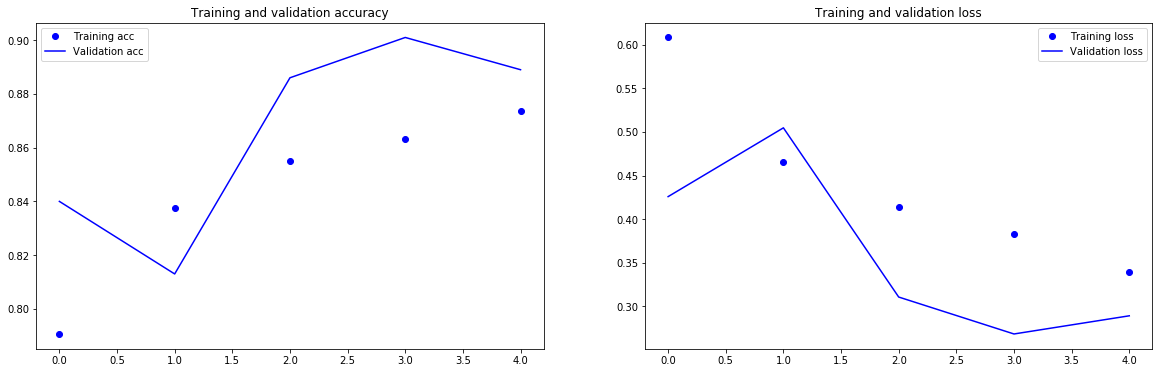

In [31]:
# historical_data.history acc and loss data over the epochs (train and validation)

range_epochs = range(n_epochs)

fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plt.plot(range_epochs, train_acc, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1,2,2)
plt.plot(range_epochs, train_loss, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(os.path.join(PATH_TO_DF, "VGG19_ft_testing_acc_loss.png"), bbox_inches='tight')
# plt.savefig(os.path.join(PATH_TO_DF, "VGG19_ft_acc_loss.png"), bbox_inches='tight')
plt.show()

In [33]:
# import h5py

# hdf5_file = h5py.File('../data/output_convnet/VGG19/VGG19_ft_model.h5', mode='r')

model_base = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)  

model_top = Sequential()  
model_top.add(Flatten(input_shape=model_base.output_shape[1:]))  
model_top.add(Dense(256, activation='relu'))  
model_top.add(Dropout(0.5))  
model_top.add(Dense(8, activation='softmax'))

model_total = Model(input= model_base.input, output= model_top(model_base.output))

# loading the weights trained before
model_total.load_weights("../data/output_convnet/VGG19/VGG19_ft_model.h5")

model_total.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy']) 

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  del sys.path[0]


In [34]:
test_convnet = ImageDataGenerator(rescale=1. / 255)

test_generator = test_convnet.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle =False,
    class_mode='categorical')

Found 1000 images belonging to 8 classes.


In [35]:
steps = int(math.ceil(n_test_samples / batch_size))

(loss, acc) = model_total.evaluate_generator(test_generator, steps=steps)

print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

acc: 89.60% - loss: 0.378759


In [36]:
predictions = model_total.predict_generator(test_generator, steps = steps)

In [37]:
from sklearn.metrics import confusion_matrix

PATH_TO_IMG = "../data/input_dataset"

prediction_list = []
real_label_list = []

cat_dict = test_generator.class_indices # the key attribute
inverse_coding = {value: key for key, value in cat_dict.items()} # dict of categories

for label in test_generator.classes:
    real_label_list.append(inverse_coding[label])
    
for prediction in predictions:
    prediction_list.append(inverse_coding[np.argmax(prediction)])

# in order to get the confusion matrix
class_names = sorted([folder for folder in os.listdir(PATH_TO_IMG)
                  if os.path.isdir(os.path.join(PATH_TO_IMG, folder))])
prediction_list_arr = np.array(prediction_list) 
real_label_list_arr = np.array(real_label_list)

VGG19_cm_ft = confusion_matrix(real_label_list_arr,prediction_list_arr)

In [38]:
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)

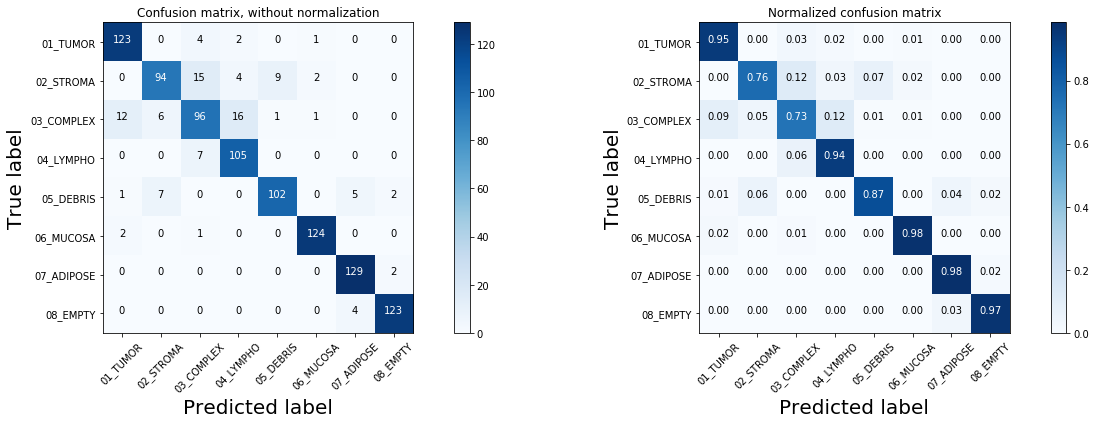

In [40]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(VGG19_cm_ft, classes=class_names,
                      title='Confusion matrix, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(VGG19_cm_ft, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig(os.path.join(PATH_TO_DF, "VGG16_ft_test.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()